In [98]:
import xgboost
import geopandas as gpd
import numpy as np
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [46]:
features = ['white_alone_percent_cen', 'black_alone_percent_cen',
       'indigenous_alone_percent_cen', 'asian_alone_percent_cen',
       'pacific_islander_alone_percent_cen', 'other_alone_percent_cen',
       'multiracial_percent_cen', 'work_from_home_percent_cen',
       'automobile_to_work_percent_cen', 'public_transit_to_work_percent_cen',
       'taxi_to_work_percent_cen', 'motorcycle_to_work_percent_cen',
       'bike_to_work_percent_cen', 'walk_to_work_percent_cen',
       'other_to_work_percent_cen', 'lt_9th_percent_cen',
       'no_diploma_percent_cen', 'high_school_percent_cen',
       'some_college_percent_cen', 'associates_percent_cen',
       'bachelors_percent_cen', 'graduate_degree_percent_cen',
       'in_labor_force_20_64_percent_cen',
       'not_in_labor_force_20_64_percent_cen', 'unemployed_20_64_percent_cen',
       'below_poverty_line_percent_cen', 'median_household_income_cen',
       'median_age_cen', 'polling_accessible','walking_transit_travel_time','driving_travel_time']

In [48]:
data = gpd.read_file('../project_data/final_dataset/train_final_dataset_Chicago_no_outlier.geojson')
X= data[features]
y= data['VoterTurnoutPercentage'].values

In [49]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.20)

# Baseline model

In [50]:
class baseline():
    def __init__(self):
        self.y_predict = None
    def fit(self, X_train,y_train):

        self.y_predict = np.mean(y_train)

    def predict(self, X_predict):
        return self.y_predict * np.ones(len(X_predict))
        

        
        
    

In [111]:

base = baseline()
base.fit(X_train, y_train)
y_predict_base = base.predict(X_val)
rmse_base = root_mean_squared_error(y_predict_base, y_val)
print(rmse_base)

9.925005967818715


So the number to beat is ~9-10% (after rerunning a few times)

# Linear regression

In [120]:
pipe_lr = Pipeline([('scale',StandardScaler()),('reg',LinearRegression())])
pipe_lr.fit(X_train,y_train)
y_predict_lr = pipe_lr.predict(X_val)
rmse_lr = root_mean_squared_error(y_predict_lr, y_val)
print(rmse_lr)

6.376145823180819


# XGBoost

In [113]:
xgb_reg = xgboost.XGBRegressor(learning_rate=.05,
                                   max_depth=5,
                                   n_estimators=100,verbosity=3)
xgb_reg.fit(X_train, y_train,eval_set=[(X_val, y_val)])
y_predict_xgb = xgb_reg.predict(X_val)
rmse_xgb = root_mean_squared_error(y_predict_xgb, y_val)


[14:04:38] ======== Monitor (0): HostSketchContainer ========
[14:04:38] AllReduce: 0.001469s, 1 calls @ 1469us

[14:04:38] MakeCuts: 0.001636s, 1 calls @ 1636us

[14:04:38] DEBUG: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/gbm/gbtree.cc:130: Using tree method: 0
[0]	validation_0-rmse:9.63246
[1]	validation_0-rmse:9.35064
[2]	validation_0-rmse:9.10122
[3]	validation_0-rmse:8.86405
[4]	validation_0-rmse:8.65224
[5]	validation_0-rmse:8.43473
[6]	validation_0-rmse:8.24672
[7]	validation_0-rmse:8.08315
[8]	validation_0-rmse:7.92139
[9]	validation_0-rmse:7.77800
[10]	validation_0-rmse:7.64408
[11]	validation_0-rmse:7.51981
[12]	validation_0-rmse:7.40413
[13]	validation_0-rmse:7.29211
[14]	validation_0-rmse:7.20162
[15]	validation_0-rmse:7.11620
[16]	validation_0-rmse:7.03357
[17]	validation_0-rmse:6.93976
[18]	validation_0-rmse:6.86601
[19]	validation_0-rmse:6.79903
[20]	validation_0-rmse:6.74001
[21]	validation_0-rmse:6.68820
[22]	validation_0-rmse:6.64

In [114]:
print(rmse_xgb)

6.156601463455593


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

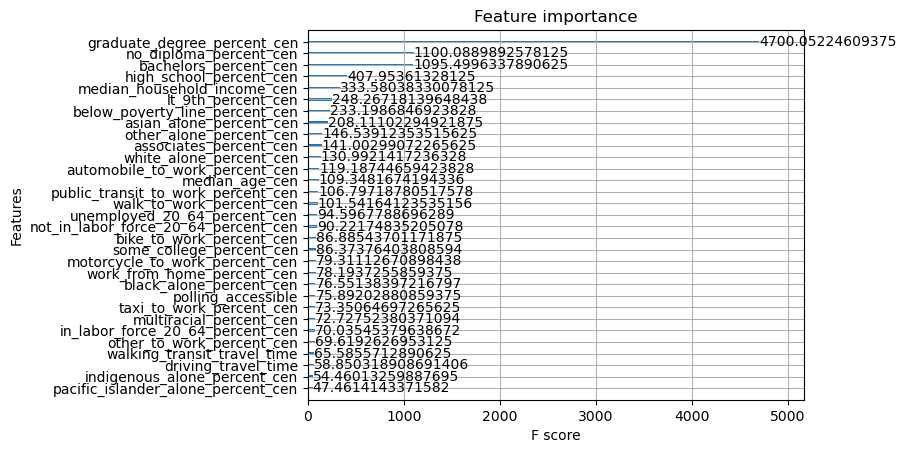

In [115]:
xgboost.plot_importance(xgb_reg, importance_type = 'gain')

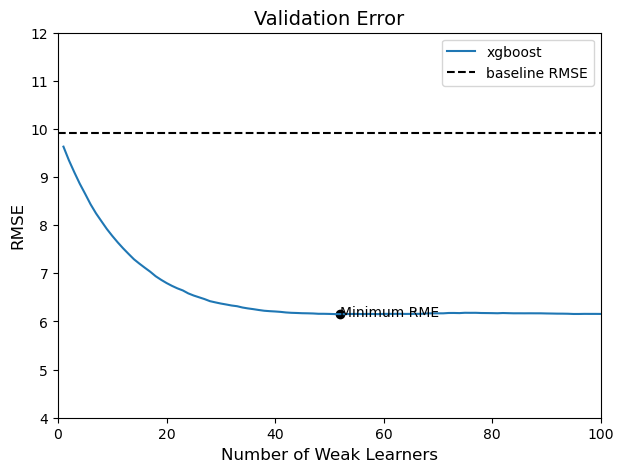

In [122]:
plt.figure(figsize=(7,5))

plt.plot(range(1,len(xgb_reg.evals_result()['validation_0']['rmse'])+1), 
         xgb_reg.evals_result()['validation_0']['rmse'], label = 'xgboost')
plt.scatter([range(1,len(xgb_reg.evals_result()['validation_0']['rmse'])+1)[np.argmin(xgb_reg.evals_result()['validation_0']['rmse'])]], 
            [np.min(xgb_reg.evals_result()['validation_0']['rmse'])], c='k')
plt.text(range(1,len(xgb_reg.evals_result()['validation_0']['rmse'])+1)[np.argmin(xgb_reg.evals_result()['validation_0']['rmse'])], 
         np.min(xgb_reg.evals_result()['validation_0']['rmse'])-.05, "Minimum RME", fontsize=10)

plt.hlines(baseline_rmse, 0,200, linestyle='--',color = 'k',label = 'baseline RMSE')

plt.title("Validation Error. Learning Rate = .05, max depth = 5", fontsize=14)
plt.xlabel("Number of Weak Learners", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.xlim(0,100)
plt.ylim(4,12)
plt.legend()
plt.show()

In [121]:
print('Baseline RMSE: {}'.format(rmse_base))
print('Linear Regression RMSE: {}'.format(rmse_lr))
print('XGBoost RMSE: {}'.format(rmse_xgb))

Baseline RMSE: 9.925005967818715
Linear Regression RMSE: 6.376145823180819
XGBoost RMSE: 6.156601463455593
